In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [3]:
# embedding_path = "./Data/hebart49_scaled_embedding_weighted_entropy_scores.csv"
# embedding_path = "./Data/things_hba_weighted_entropy_scores.csv"
embedding_path = "./Data/things_embedding_v10_lora_weighted_entropy_scores.csv"
hdf5_file = '../output/things_entropy_rdm.hdf5'

In [4]:
df = pd.read_csv(embedding_path)
df

,image,Entropy,Entropy Change,Weighted Entropy
0,aardvark_01b.jpg,2.129475,0.951958,3.081433
1,abacus_01b.jpg,3.456033,0.542173,3.998206
2,accordion_01b.jpg,3.357678,0.550358,3.908036
3,acorn_01b.jpg,3.503027,0.520730,4.023757
4,air_conditioner_01b.jpg,3.103253,0.592800,3.696053
...,...,...,...,...
1849,yoke_01s.jpg,3.317849,0.673515,3.991364
1850,yolk_01b.jpg,3.332968,0.602495,3.935463
1851,zebra_01b.jpg,2.423744,0.915484,3.339227
1852,zipper_01b.jpg,3.185150,0.738635,3.923785


In [6]:
embedding = df.iloc[:, -1].values
embedding.shape

(1854,)

In [7]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

# Assuming `embedding` is your 1D array of shape (1854,)
embedding = df.iloc[:, -1].values

# Reshape the embedding to a 2D array for distance computation
embedding_reshaped = embedding.reshape(-1, 1)

# Compute the pairwise Euclidean distances
rdm = squareform(pdist(embedding_reshaped, metric='euclidean'))

# Verify the shape of the RDM
print(rdm.shape)  # Should print (1854, 1854)


(1854, 1854)


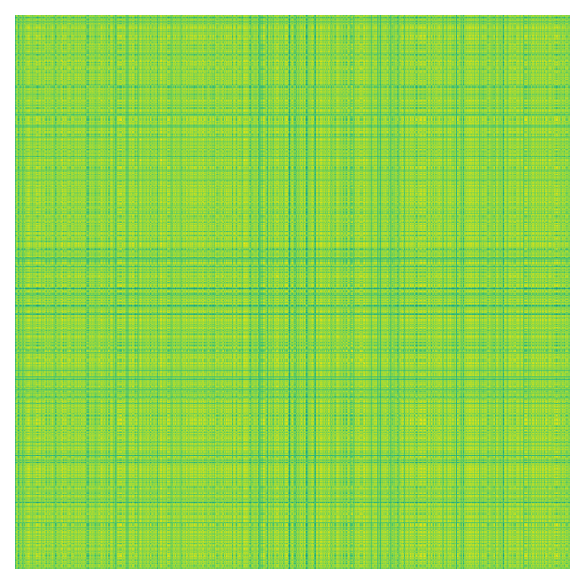

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(dpi=150)  # Create a new figure and axes with 150 dpi resolution
fig.patch.set_facecolor('none')  # Set the figure facecolor to none
ax.set_facecolor('none')  # Set the axes facecolor to none

im = ax.imshow(rdm, cmap='viridis_r')  # Display the image

ax.axis('off')  # Remove the x and y axis labels

plt.show()

In [9]:
# export rdm to hdf5
import h5py
with h5py.File(hdf5_file, 'w') as f:
    # Create a dataset and write the rdm array
    f.create_dataset('rdm', data=rdm)


loading Things MEG RDM
loading Complexity RDMs
processing Complexity model correlation
processing Permuted Complexity model correlation
performing Wilcoxon signed rank test
plotting


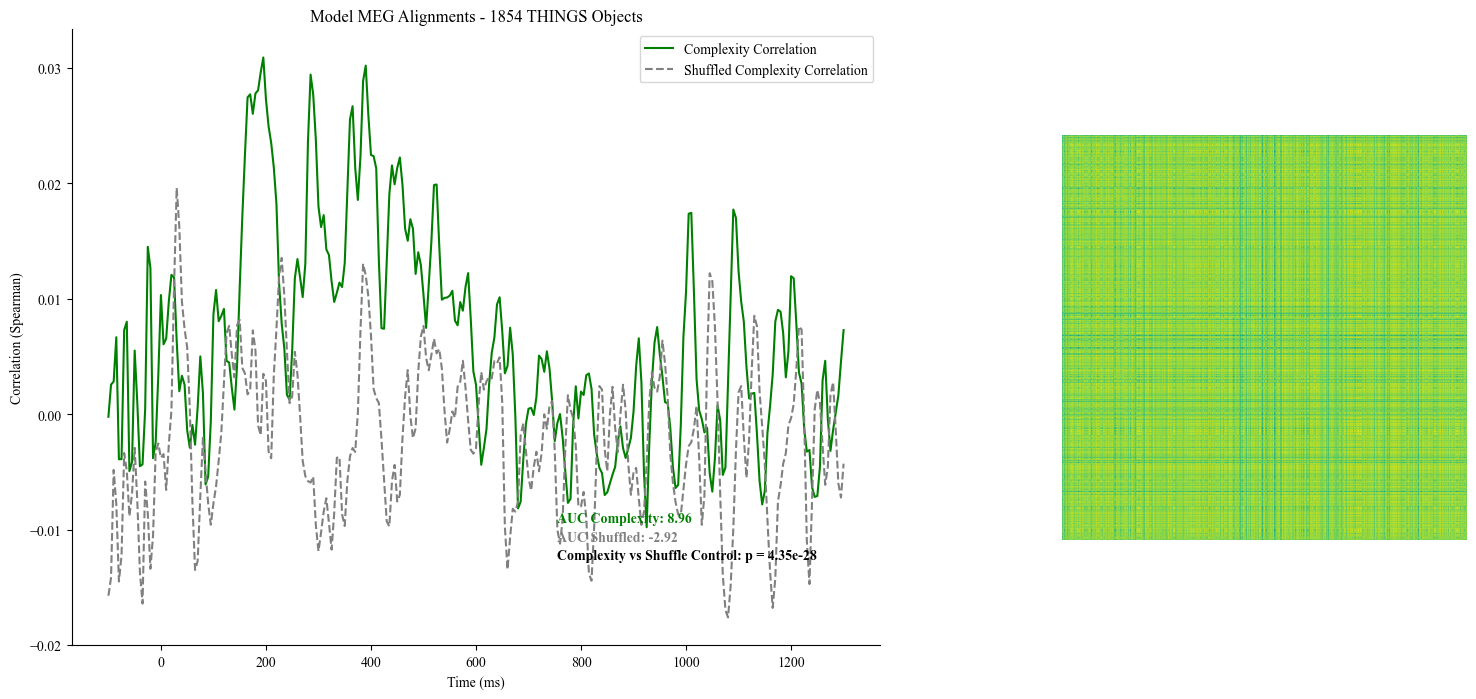

In [8]:
import h5py
import numpy as np
from scipy.stats import spearmanr, wilcoxon
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm import tqdm
import os
from numpy import trapz

plt.rcParams['font.family'] = 'Times New Roman'

def compute_group_mean_rdm(exclude_index):
    group_rdms = np.delete(all_rdms, exclude_index, axis=0)
    mean_rdms = np.mean(group_rdms, axis=0)
    return mean_rdms

def calculate_model_correlation(group_mean_rdms, model_rdm_flat):
    model_correlations = []
    for time_point in range(group_mean_rdms.shape[0]):
        indices = np.triu_indices_from(group_mean_rdms[time_point], k=1)
        group_mean_rdm_flat = group_mean_rdms[time_point][indices]
        corr, _ = spearmanr(model_rdm_flat, group_mean_rdm_flat, nan_policy='omit')
        model_correlations.append(corr)
    return model_correlations

def permute_rdm(rdm):
    permutation = np.random.permutation(rdm.shape[0])
    permuted_rdm = rdm[permutation][:, permutation]
    return permuted_rdm

def calculate_permuted_correlations(model_rdm, group_mean_rdms, num_permutations):
    permuted_correlations = []
    for _ in range(num_permutations):
        permuted_model_rdm = permute_rdm(model_rdm)
        indices = np.triu_indices_from(permuted_model_rdm, k=1)
        permuted_model_rdm_flat = permuted_model_rdm[indices]
        model_correlations = calculate_model_correlation(group_mean_rdms, permuted_model_rdm_flat)
        permuted_correlations.append(model_correlations)
    return np.array(permuted_correlations)

def permutation_testing(args):
    model_rdm, group_mean_rdms, num_permutations = args
    return calculate_permuted_correlations(model_rdm, group_mean_rdms, num_permutations)

def load_dynamic_rdms(dynamic_rdm_dir):
    dynamic_rdms = {}
    for rdm_file in sorted(os.listdir(dynamic_rdm_dir)):
        if rdm_file.endswith('.hdf5'):
            time_ms = int(rdm_file.split('_')[-1][:-7])  # Extract time in ms from filename
            with h5py.File(os.path.join(dynamic_rdm_dir, rdm_file), 'r') as f:
                dynamic_rdms[time_ms] = f['rdm'][:]
    return dynamic_rdms

def fdr_correction(p_values, alpha=0.05):
    p_values_sorted = np.sort(p_values)
    p_values_indices = np.argsort(p_values)
    n = len(p_values)
    fdr_threshold = np.arange(1, n+1) * (alpha / n)
    below_threshold = p_values_sorted <= fdr_threshold
    max_below = np.max(np.where(below_threshold)[0]) if np.any(below_threshold) else -1
    corrected_threshold = p_values_sorted[max_below] if max_below >= 0 else 0
    return p_values <= corrected_threshold

def flatten_upper_triangles(rdms):
    if rdms.ndim == 3:

        # Get the upper triangle indices for one matrix (all matrices have the same shape)
        triu_indices = np.triu_indices_from(rdms[0], k=1)
        
        # Flatten the upper triangles of all matrices
        flattened_rdms = np.array([matrix[triu_indices] for matrix in rdms])

        return flattened_rdms
    elif rdms.ndim == 2:
        triu_indices = np.triu_indices_from(rdms, k=1)
        return rdms[triu_indices]

def calculate_individual_correlation(model_rdms, p_rdms):
    model_correlations = []
    print(model_rdms.shape)
    print(p_rdms.shape)

    for i in range(281):
        model_rdm_flat = flatten_upper_triangles(model_rdms)
        p_rdm_flat = flatten_upper_triangles(p_rdms[i])
        corr, _ = spearmanr(model_rdm_flat, p_rdm_flat, nan_policy='omit')
        model_correlations.append(corr)
    print(model_correlations)

    return model_correlations


if __name__ == '__main__':
    # Ensure the figures directory exists
    figures_dir = './figures'
    if not os.path.exists(figures_dir):
        os.makedirs(figures_dir)

    # Load the .mat file
    meg_rdm = "./Data/ThingsMEG_RDMs/THingsMEG_RDM_4P.npy"
    print("loading Things MEG RDM")
    all_rdms = np.load(meg_rdm, allow_pickle=True)

    # Paths for model RDMs
    x_rdm_path = hdf5_file

    # Load the models' RDMs
    print("loading Complexity RDMs")
    with h5py.File(x_rdm_path, 'r') as f:
        x_rdm = f['rdm'][:]
        indices = np.triu_indices_from(x_rdm, k=1)
        x_rdm_flat = x_rdm[indices]

    # Create a permuted (shuffled) version of x_rdm
    x_rdm_permuted = permute_rdm(x_rdm)
    x_rdm_permuted_flat = x_rdm_permuted[indices]

    overall_group_mean_rdms = np.mean(all_rdms, axis=0) # Compute group mean RDMs including all subjects
    print("processing Complexity model correlation")
    x_correlations = calculate_model_correlation(overall_group_mean_rdms, x_rdm_flat)

    print("processing Permuted Complexity model correlation")
    x_permuted_correlations = calculate_model_correlation(overall_group_mean_rdms, x_rdm_permuted_flat)
    

    # Time points for plotting
    time_points = np.linspace(-100, 1300, 281)

    # Perform signed rank Wilcoxon test for each time point
    print("performing Wilcoxon signed rank test")
    p = wilcoxon(x_correlations, x_permuted_correlations).pvalue

    print("plotting")
    # Plotting
    # Create a figure with a grid layout
    fig = plt.figure(figsize=(18, 8))
    plt.rcParams['font.family'] = 'Times New Roman'  # Set font to Times New Roman
    gs = fig.add_gridspec(1, 2, width_ratios=[2, 1], wspace=0.3)

    # Plot 1: Correlation plots
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(time_points, x_correlations, label='Complexity Correlation', color='green')
    ax1.plot(time_points, x_permuted_correlations, label='Shuffled Complexity Correlation', color='grey', linestyle='--')

    ax1.set_xlabel('Time (ms)')
    ax1.set_ylabel('Correlation (Spearman)')
    ax1.set_title('Model MEG Alignments - 1854 THINGS Objects')
    ax1.legend()

    # Remove top and right frame
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    # Calculate AUC for each correlation curve
    auc_x = trapz(x_correlations, dx=np.diff(time_points)[0])
    auc_x_permuted = trapz(x_permuted_correlations, dx=np.diff(time_points)[0])

    # Annotate AUC values
    plt.annotate(f'AUC Complexity: {auc_x:.2f}', xy=(0.6, 0.20), xycoords='axes fraction', color='green', size=10, weight='bold')
    plt.annotate(f'AUC Shuffled: {auc_x_permuted:.2f}', xy=(0.6, 0.17), xycoords='axes fraction', color='grey', size=10, weight='bold')
    plt.annotate(f'Complexity vs Shuffle Control: p = {p:.2e}', xy=(0.6, 0.14), xycoords='axes fraction', color='black', size=10, weight='bold')

    # Plot 2: RDM plot
    ax2 = fig.add_subplot(gs[0, 1])
    fig.patch.set_facecolor('none')  # Set the figure facecolor to none
    ax2.set_facecolor('none')  # Set the axes facecolor to none

    im = ax2.imshow(rdm, cmap='viridis_r')  # Display the image

    ax2.axis('off')  # Remove the x and y axis labels

    plt.show()


loading Things MEG RDM
loading Complexity RDMs
processing Complexity model correlation
processing Permuted Complexity model correlation
performing Wilcoxon signed rank test
plotting


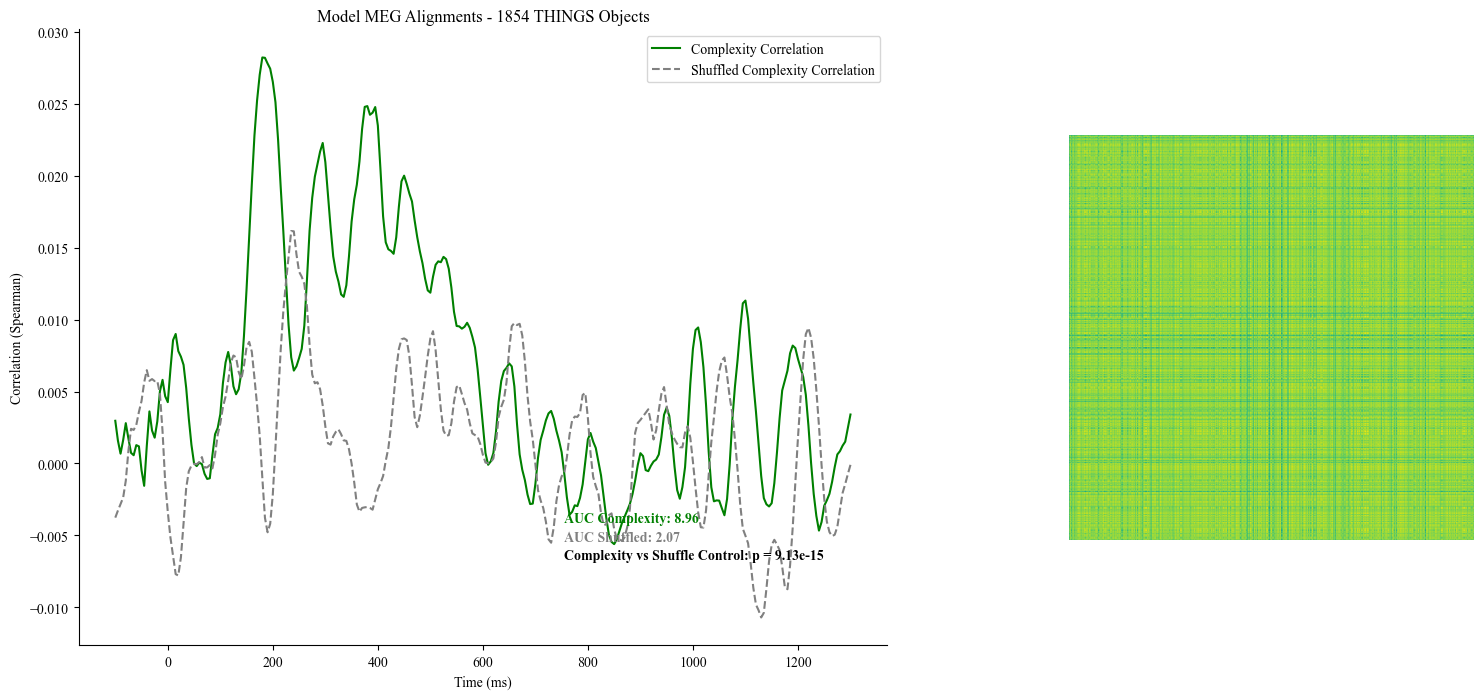

In [12]:
import h5py
import numpy as np
from scipy.stats import spearmanr, wilcoxon
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm import tqdm
import os
from numpy import trapz

plt.rcParams['font.family'] = 'Times New Roman'

def compute_group_mean_rdm(exclude_index):
    group_rdms = np.delete(all_rdms, exclude_index, axis=0)
    mean_rdms = np.mean(group_rdms, axis=0)
    return mean_rdms

# def calculate_model_correlation(group_mean_rdms, model_rdm_flat):
#     model_correlations = []
#     for time_point in range(group_mean_rdms.shape[0]):
#         indices = np.triu_indices_from(group_mean_rdms[time_point], k=1)
#         group_mean_rdm_flat = group_mean_rdms[time_point][indices]
#         corr, _ = spearmanr(model_rdm_flat, group_mean_rdm_flat, nan_policy='omit')
#         model_correlations.append(corr)
#     return model_correlations
def calculate_model_correlation(group_mean_rdms, model_rdm_flat):
    model_correlations = []
    n_timepoints = group_mean_rdms.shape[0]

    for time_point in range(n_timepoints):
        correlations = []
        for t in range(max(0, time_point - 3), min(n_timepoints, time_point + 4)):
            indices = np.triu_indices_from(group_mean_rdms[t], k=1)
            group_mean_rdm_flat = group_mean_rdms[t][indices]
            corr, _ = spearmanr(model_rdm_flat, group_mean_rdm_flat, nan_policy='omit')
            correlations.append(corr)
        mean_corr = np.mean(correlations) if correlations else np.nan
        model_correlations.append(mean_corr)

    return model_correlations
def permute_rdm(rdm):
    permutation = np.random.permutation(rdm.shape[0])
    permuted_rdm = rdm[permutation][:, permutation]
    return permuted_rdm

def calculate_permuted_correlations(model_rdm, group_mean_rdms, num_permutations):
    permuted_correlations = []
    for _ in range(num_permutations):
        permuted_model_rdm = permute_rdm(model_rdm)
        indices = np.triu_indices_from(permuted_model_rdm, k=1)
        permuted_model_rdm_flat = permuted_model_rdm[indices]
        model_correlations = calculate_model_correlation(group_mean_rdms, permuted_model_rdm_flat)
        permuted_correlations.append(model_correlations)
    return np.array(permuted_correlations)

def permutation_testing(args):
    model_rdm, group_mean_rdms, num_permutations = args
    return calculate_permuted_correlations(model_rdm, group_mean_rdms, num_permutations)

def load_dynamic_rdms(dynamic_rdm_dir):
    dynamic_rdms = {}
    for rdm_file in sorted(os.listdir(dynamic_rdm_dir)):
        if rdm_file.endswith('.hdf5'):
            time_ms = int(rdm_file.split('_')[-1][:-7])  # Extract time in ms from filename
            with h5py.File(os.path.join(dynamic_rdm_dir, rdm_file), 'r') as f:
                dynamic_rdms[time_ms] = f['rdm'][:]
    return dynamic_rdms

def fdr_correction(p_values, alpha=0.05):
    p_values_sorted = np.sort(p_values)
    p_values_indices = np.argsort(p_values)
    n = len(p_values)
    fdr_threshold = np.arange(1, n+1) * (alpha / n)
    below_threshold = p_values_sorted <= fdr_threshold
    max_below = np.max(np.where(below_threshold)[0]) if np.any(below_threshold) else -1
    corrected_threshold = p_values_sorted[max_below] if max_below >= 0 else 0
    return p_values <= corrected_threshold

def flatten_upper_triangles(rdms):
    if rdms.ndim == 3:

        # Get the upper triangle indices for one matrix (all matrices have the same shape)
        triu_indices = np.triu_indices_from(rdms[0], k=1)
        
        # Flatten the upper triangles of all matrices
        flattened_rdms = np.array([matrix[triu_indices] for matrix in rdms])

        return flattened_rdms
    elif rdms.ndim == 2:
        triu_indices = np.triu_indices_from(rdms, k=1)
        return rdms[triu_indices]

def calculate_individual_correlation(model_rdms, p_rdms):
    model_correlations = []
    print(model_rdms.shape)
    print(p_rdms.shape)

    for i in range(281):
        model_rdm_flat = flatten_upper_triangles(model_rdms)
        p_rdm_flat = flatten_upper_triangles(p_rdms[i])
        corr, _ = spearmanr(model_rdm_flat, p_rdm_flat, nan_policy='omit')
        model_correlations.append(corr)
    print(model_correlations)

    return model_correlations


if __name__ == '__main__':
    # Ensure the figures directory exists
    figures_dir = './figures'
    if not os.path.exists(figures_dir):
        os.makedirs(figures_dir)

    # Load the .mat file
    meg_rdm = "./Data/ThingsMEG_RDMs/THingsMEG_RDM_4P.npy"
    print("loading Things MEG RDM")
    all_rdms = np.load(meg_rdm, allow_pickle=True)

    # Paths for model RDMs
    x_rdm_path = hdf5_file

    # Load the models' RDMs
    print("loading Complexity RDMs")
    with h5py.File(x_rdm_path, 'r') as f:
        x_rdm = f['rdm'][:]
        indices = np.triu_indices_from(x_rdm, k=1)
        x_rdm_flat = x_rdm[indices]

    # Create a permuted (shuffled) version of x_rdm
    x_rdm_permuted = permute_rdm(x_rdm)
    x_rdm_permuted_flat = x_rdm_permuted[indices]

    overall_group_mean_rdms = np.mean(all_rdms, axis=0) # Compute group mean RDMs including all subjects
    print("processing Complexity model correlation")
    x_correlations = calculate_model_correlation(overall_group_mean_rdms, x_rdm_flat)

    print("processing Permuted Complexity model correlation")
    x_permuted_correlations = calculate_model_correlation(overall_group_mean_rdms, x_rdm_permuted_flat)
    

    # Time points for plotting
    time_points = np.linspace(-100, 1300, 281)

    # Perform signed rank Wilcoxon test for each time point
    print("performing Wilcoxon signed rank test")
    p = wilcoxon(x_correlations, x_permuted_correlations).pvalue

    print("plotting")
    # Plotting
    # Create a figure with a grid layout
    fig = plt.figure(figsize=(18, 8))
    plt.rcParams['font.family'] = 'Times New Roman'  # Set font to Times New Roman
    gs = fig.add_gridspec(1, 2, width_ratios=[2, 1], wspace=0.3)

    # Plot 1: Correlation plots
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(time_points, x_correlations, label='Complexity Correlation', color='green')
    ax1.plot(time_points, x_permuted_correlations, label='Shuffled Complexity Correlation', color='grey', linestyle='--')

    ax1.set_xlabel('Time (ms)')
    ax1.set_ylabel('Correlation (Spearman)')
    ax1.set_title('Model MEG Alignments - 1854 THINGS Objects')
    ax1.legend()

    # Remove top and right frame
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    # Calculate AUC for each correlation curve
    auc_x = trapz(x_correlations, dx=np.diff(time_points)[0])
    auc_x_permuted = trapz(x_permuted_correlations, dx=np.diff(time_points)[0])

    # Annotate AUC values
    plt.annotate(f'AUC Complexity: {auc_x:.2f}', xy=(0.6, 0.20), xycoords='axes fraction', color='green', size=10, weight='bold')
    plt.annotate(f'AUC Shuffled: {auc_x_permuted:.2f}', xy=(0.6, 0.17), xycoords='axes fraction', color='grey', size=10, weight='bold')
    plt.annotate(f'Complexity vs Shuffle Control: p = {p:.2e}', xy=(0.6, 0.14), xycoords='axes fraction', color='black', size=10, weight='bold')

    # Plot 2: RDM plot
    ax2 = fig.add_subplot(gs[0, 1])
    fig.patch.set_facecolor('none')  # Set the figure facecolor to none
    ax2.set_facecolor('none')  # Set the axes facecolor to none

    im = ax2.imshow(rdm, cmap='viridis_r')  # Display the image

    ax2.axis('off')  # Remove the x and y axis labels

    plt.show()
